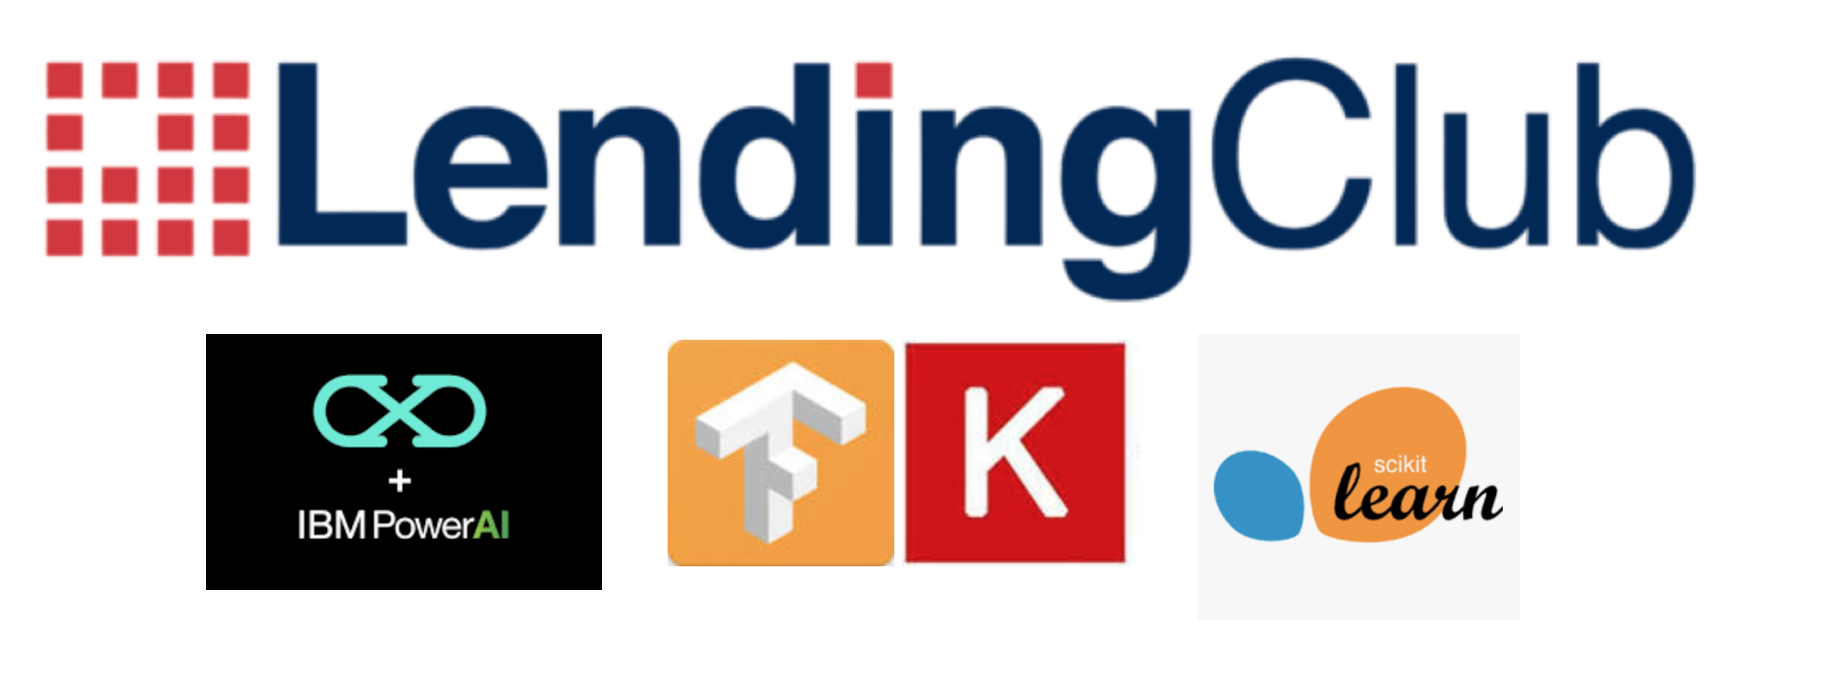


## Building a lender recommender model for loans. 

Contents

    Load the data
    Develop models - iterating to a better design
      Train/evaluate a model
      Train/evaluate a bigger model
      Train/evaluate/test a bigger model with regulation (via dropout)
    Summary


### Load the prepared data and split it for training, validation, and testing.  

The original dataset came from LendingClub and was refined and preparred for model training in a notebook created by Bob Chesebrough and Dustin VanStee.   They are data scientist at the IBM Cognitive Systems Solution Center.   See Dustin's github project at https://github.com/dustinvanstee/lendingclub-examples/tree/master/techu

In [1]:
import pandas as pd

loan_df = pd.read_csv('/project_data/data_asset/LoanStats_securev1_2016Q1_prep2.csv')

In [2]:
loan_df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,Individual,Joint App,Cash,DirectPay,N,Y,0_3yrs,4_6yrs,gt_6yrs,id
0,16000.0,16000.0,16000.0,481.84,105000.0,15.02,1.0,720.0,724.0,0.0,...,1,0,1,0,1,0,0,0,1,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,24.30,0.0,705.0,709.0,0.0,...,1,0,1,0,1,0,0,0,1,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,9.99,0.0,690.0,694.0,0.0,...,1,0,1,0,1,0,0,0,1,75993535


In [3]:
# Split the training and test data
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(loan_df, test_size=.2, random_state=42)
        
X_train = train_df.drop(['default','id'],1)
Y_train = train_df['default']
        
X_test = test_df.drop(['default','id'],1)
Y_test = test_df['default']

In [4]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True,with_std=True)
X_train_scaled = scaler.fit_transform(X_train)   # same as (df-df.mean())/df.std(ddof=0)
X_test_scaled = scaler.transform(X_test)   # 
        
X_train_scaled = pd.DataFrame(data=X_train_scaled,columns=X_train.columns)
X_test_scaled  = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)
    
print("Training set size: " + str(train_df.shape))
print("Testing set size: " + str(test_df.shape))

X_val = X_train_scaled[:10000]
X_train_partial = X_train_scaled[10000:]

print("X Training partial set size: " + str(X_train_partial.shape))
print("X Validation set size: " + str(X_val.shape))

Y_val = Y_train[:10000]
Y_train_partial = Y_train[10000:]

print("Y Training partial set size: " + str(Y_train_partial.shape))
print("Y Validation set size: " + str(Y_val.shape))

Training set size: (92628, 132)
Testing set size: (23157, 132)
X Training partial set size: (82628, 130)
X Validation set size: (10000, 130)
Y Training partial set size: (82628,)
Y Validation set size: (10000,)


### Build, train and evaluate the model 

#### Build the model

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(130,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                2096      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [7]:
history = model.fit(X_train_partial,
                    Y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, Y_val))

Train on 82628 samples, validate on 10000 samples
Epoch 1/20
82628/82628 [==============================] - 1s 16us/step - loss: 0.2820 - acc: 0.9005 - val_loss: 0.1589 - val_acc: 0.9448
Epoch 2/20
82628/82628 [==============================] - 1s 9us/step - loss: 0.1254 - acc: 0.9575 - val_loss: 0.1191 - val_acc: 0.9603
Epoch 3/20
82628/82628 [==============================] - 1s 9us/step - loss: 0.1088 - acc: 0.9627 - val_loss: 0.1120 - val_acc: 0.9628
Epoch 4/20
82628/82628 [==============================] - 1s 10us/step - loss: 0.1027 - acc: 0.9649 - val_loss: 0.1083 - val_acc: 0.9640
Epoch 5/20
82628/82628 [==============================] - 1s 9us/step - loss: 0.0987 - acc: 0.9662 - val_loss: 0.1065 - val_acc: 0.9640
Epoch 6/20
82628/82628 [==============================] - 1s 9us/step - loss: 0.0959 - acc: 0.9668 - val_loss: 0.1041 - val_acc: 0.9639
Epoch 7/20
82628/82628 [==============================] - 1s 9us/step - loss: 0.0935 - acc: 0.9680 - val_loss: 0.1041 - val_acc: 0.9

#### Visualize the training results 

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

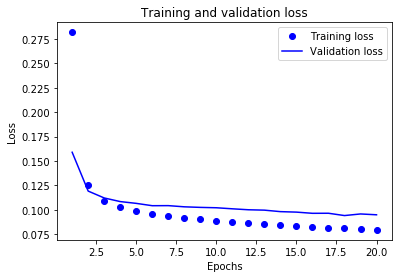

In [10]:
import matplotlib
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

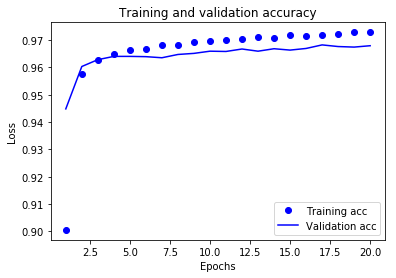

In [11]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Build, train and evaluate a bigger model

#### Build the model

In [12]:
model2 = models.Sequential()
model2.add(layers.Dense(32, activation='relu', input_shape=(130,)))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                4192      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras import optimizers

model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [14]:
history2 = model2.fit(X_train_partial,
                      Y_train_partial,
                      epochs=20,
                      batch_size=512,
                      validation_data=(X_val, Y_val))

Train on 82628 samples, validate on 10000 samples
Epoch 1/20
82628/82628 [==============================] - 1s 18us/step - loss: 0.2291 - acc: 0.9176 - val_loss: 0.1280 - val_acc: 0.9573
Epoch 2/20
82628/82628 [==============================] - 1s 10us/step - loss: 0.1141 - acc: 0.9615 - val_loss: 0.1150 - val_acc: 0.9607
Epoch 3/20
82628/82628 [==============================] - 1s 11us/step - loss: 0.1035 - acc: 0.9648 - val_loss: 0.1104 - val_acc: 0.9632
Epoch 4/20
82628/82628 [==============================] - 1s 10us/step - loss: 0.0973 - acc: 0.9669 - val_loss: 0.1068 - val_acc: 0.9636
Epoch 5/20
82628/82628 [==============================] - 1s 10us/step - loss: 0.0930 - acc: 0.9680 - val_loss: 0.1040 - val_acc: 0.9646
Epoch 6/20
82628/82628 [==============================] - 1s 11us/step - loss: 0.0897 - acc: 0.9690 - val_loss: 0.1029 - val_acc: 0.9646
Epoch 7/20
82628/82628 [==============================] - 1s 11us/step - loss: 0.0868 - acc: 0.9696 - val_loss: 0.1028 - val_acc

#### Visualize the training results

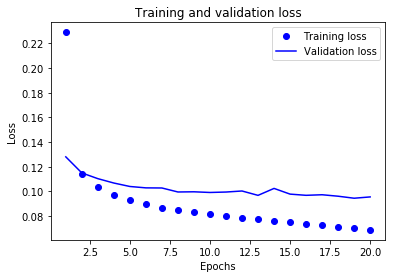

In [15]:
import matplotlib
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

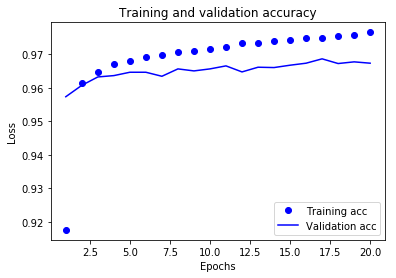

In [16]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Build, train and evaluate a bigger model with regulation via dropout

#### Build the model

In [17]:
model3 = models.Sequential()
model3.add(layers.Dense(32, activation='relu', input_shape=(130,)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                4192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total para

In [18]:
from keras import optimizers

model3.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [19]:
history3 = model3.fit(X_train_partial,
                      Y_train_partial,
                      epochs=20,
                      batch_size=512,
                      validation_data=(X_val, Y_val))

Train on 82628 samples, validate on 10000 samples
Epoch 1/20
82628/82628 [==============================] - 2s 24us/step - loss: 0.2975 - acc: 0.8847 - val_loss: 0.1314 - val_acc: 0.9562
Epoch 2/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.1397 - acc: 0.9543 - val_loss: 0.1122 - val_acc: 0.9630
Epoch 3/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.1210 - acc: 0.9602 - val_loss: 0.1076 - val_acc: 0.9640
Epoch 4/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.1138 - acc: 0.9635 - val_loss: 0.1048 - val_acc: 0.9656
Epoch 5/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.1068 - acc: 0.9644 - val_loss: 0.1029 - val_acc: 0.9646
Epoch 6/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.1038 - acc: 0.9658 - val_loss: 0.1002 - val_acc: 0.9657
Epoch 7/20
82628/82628 [==============================] - 1s 14us/step - loss: 0.0997 - acc: 0.9668 - val_loss: 0.0992 - val_acc

#### Visualize the training results

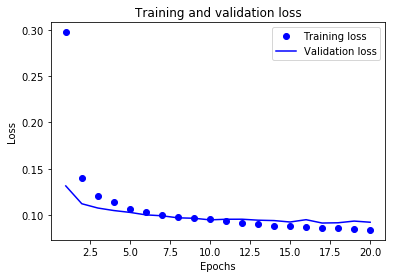

In [20]:
import matplotlib
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

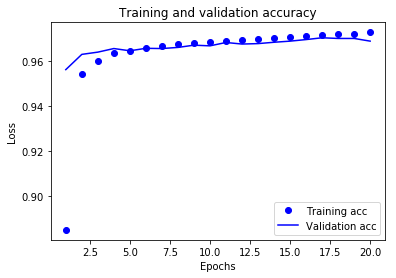

In [21]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Test the model on data is has not seen before

In [22]:
scores = model3.evaluate(X_test_scaled, Y_test, verbose=0)
print('Test loss:', scores[0])
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Test loss: 0.08840191407417852
acc: 97.08%
